## Использование модели распознавания рукописного текста на примере штампа регистрации Паспорта РФ

Архитектура модели:

![picture](https://github.com/conwerner/ocr-transformer/raw/master/diagram_model2.png)

Обучение модели: https://drive.google.com/file/d/1HE_qH8IfgfnIG-7rKd1mOF8EARJOecmK/view?usp=sharing

### Инстанс

In [69]:
import os

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd

import torch
from torch import nn
from torchvision import transforms
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d, LeakyReLU

### Константы и пути

In [70]:
!mkdir pred

mkdir: cannot create directory ‘pred’: File exists


In [71]:
from google.colab import drive
drive.mount("/content/drive")
DIR = "/content"
MODEL_DIR = "/content/drive/My Drive/Models/HandWritenOcr/"
MODEL_NAME = "ocr_transformer_4h2l_simple_conv_64x256.pt"
SAMPLES_DIR = "/content/drive/My Drive/Data/HandWritenOcr/"

PREDICT_PATH = "/content/pred"
PATH_TEST_RESULTS = DIR+"/test_result.csv"
PATH_TEST_DIR = "/content/drive/My Drive/Data/HandWritenLbls/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Конфиги

In [72]:
ALPHABET = ['PAD', 'SOS', ' ', '!', '"', '%', '(', ')', ',', '-', '.', '/',
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
            '[', ']', '«', '»', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И',
            'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х',
            'Ц', 'Ч', 'Ш', 'Щ', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е',
            'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т',
            'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я',
            'ё', 'EOS']


DEVICE = 'cuda:0'
HIDDEN = 512
ENC_LAYERS = 2
DEC_LAYERS = 2
N_HEADS = 4
DROPOUT = 0.2

WIDTH = 256
HEIGHT = 64
CHANNELS = 1

BATCH_SIZE = 16

### Примеры штампов

Всего примеров документа: 10 , 10 первых:


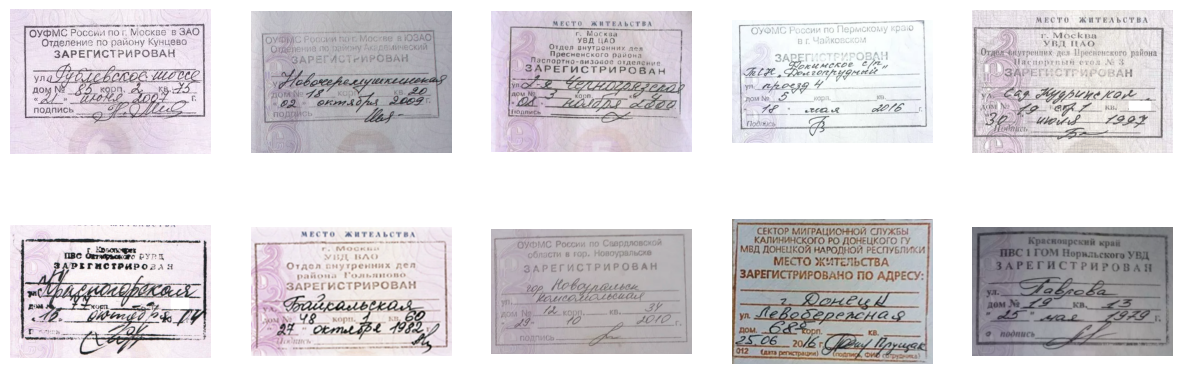

In [73]:
# Примеры изображений
pas_list = []

for i in os.listdir(SAMPLES_DIR):
    pas_list.append(f"{SAMPLES_DIR}/{i}")

df_links = pd.DataFrame(pas_list, columns=["LINKS"])
print("Всего примеров документа:", len(df_links["LINKS"]), ", 10 первых:")

# Фигура визуализации изображений
fig = plt.figure(figsize=(15,5))
x = 1

# Чтение изображений для фигуры в цикле
for i in df_links["LINKS"][0:10]:

    img = cv2.imread(i)
    fig.add_subplot(2,5,x)
    plt.imshow(img)
    plt.axis('off')
    x += 1

plt.show()

### Модель

In [74]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.scale = torch.nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def log_config(model):
    print('transformer layers: {}'.format(model.enc_layers))
    print('transformer heads: {}'.format(model.transformer.nhead))
    print('hidden dim: {}'.format(model.decoder.embedding_dim))
    print('num classes: {}'.format(model.decoder.num_embeddings))
    print('backbone: {}'.format(model.backbone_name))
    print('dropout: {}'.format(model.pos_encoder.dropout.p))
    print(f'{count_parameters(model):,} trainable parameters')

In [75]:
class TransformerModel(nn.Module):
    def __init__(self, outtoken, hidden, enc_layers=1, dec_layers=1, nhead=1, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.backbone_name = 'conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)'

        self.conv0 = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv1 = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        self.conv3 = Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        self.conv5 = Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv6 = Conv2d(512, 512, kernel_size=(2, 1), stride=(1, 1))

        self.pool1 = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool3 = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)

        self.bn0 = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn1 = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn2 = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn3 = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn4 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn5 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn6 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.activ = LeakyReLU()

        self.pos_encoder = PositionalEncoding(hidden, dropout)
        self.decoder = nn.Embedding(outtoken, hidden)
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        self.transformer = nn.Transformer(d_model=hidden, nhead=nhead, num_encoder_layers=enc_layers,
                                          num_decoder_layers=dec_layers, dim_feedforward=hidden * 4, dropout=dropout)

        self.fc_out = nn.Linear(hidden, outtoken)
        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None

        log_config(self)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=DEVICE), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)

    def _get_features(self, src):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        returns
        ---
        x : Tensor : [W,B,CH]
        '''
        x = self.activ(self.bn0(self.conv0(src)))
        x = self.pool1(self.activ(self.bn1(self.conv1(x))))
        x = self.activ(self.bn2(self.conv2(x)))
        x = self.pool3(self.activ(self.bn3(self.conv3(x))))
        x = self.activ(self.bn4(self.conv4(x)))
        x = self.pool5(self.activ(self.bn5(self.conv5(x))))
        x = self.activ(self.bn6(self.conv6(x)))
        x = x.permute(0, 3, 1, 2).flatten(2).permute(1, 0, 2)
        return x

    def predict(self, batch):
        '''
        params
        ---
        batch : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width

        returns
        ---
        result : List [64, -1] : [B, -1]
            preticted sequences of tokens' indexes
        '''
        result = []
        for item in batch:
            x = self._get_features(item.unsqueeze(0))
            memory = self.transformer.encoder(self.pos_encoder(x))
            out_indexes = [ALPHABET.index('SOS'), ]
            for i in range(100):
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(DEVICE)
                output = self.fc_out(self.transformer.decoder(self.pos_decoder(self.decoder(trg_tensor)), memory))

                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == ALPHABET.index('EOS'):
                    break
            result.append(out_indexes)
        return result

    def forward(self, src, trg):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        trg : Tensor [13, 64] : [L,B]
            L - max length of label
        '''
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device)

        x = self._get_features(src)
        src_pad_mask = self.make_len_mask(x[:, :, 0])
        src = self.pos_encoder(x)
        trg_pad_mask = self.make_len_mask(trg)
        trg = self.decoder(trg)
        trg = self.pos_decoder(trg)

        output = self.transformer(src, trg, src_mask=self.src_mask, tgt_mask=self.trg_mask,
                                  memory_mask=self.memory_mask,
                                  src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=trg_pad_mask,
                                  memory_key_padding_mask=src_pad_mask)
        output = self.fc_out(output)

        return output

### Загрузка модели

In [76]:
model = TransformerModel(
    len(ALPHABET),
    hidden=HIDDEN,
    enc_layers=ENC_LAYERS,
    dec_layers=DEC_LAYERS,
    nhead=N_HEADS,
    dropout=DROPOUT
    ).to(DEVICE)

model.load_state_dict(torch.load(f"{MODEL_DIR}{MODEL_NAME}"))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


transformer layers: 2
transformer heads: 4
hidden dim: 512
num classes: 92
backbone: conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)
dropout: 0.2
19,838,174 trainable parameters


<All keys matched successfully>

### Тест

In [77]:
def process_image(img):
    """
    params:
    ---
    img : np.array
    returns
    ---
    img : np.array
    """
    w, h, _ = img.shape
    new_w = HEIGHT
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h, _ = img.shape

    img = img.astype('float32')

    new_h = WIDTH
    if h < new_h:
        add_zeros = np.full((w, new_h - h, 3), 255)
        img = np.concatenate((img, add_zeros), axis=1)

    if h > new_h:
        img = cv2.resize(img, (new_h, new_w))

    return img


def pred_2_text(pred_indicies):
    result_list = [ALPHABET[i] for i in pred_indicies[0]]
    result = ""
    for i in result_list:
        if i not in ["SOS", "EOS"]:
            result += i
    return result


def indicies_to_text(indexes, idx2char):
    text = "".join([idx2char[i] for i in indexes])
    text = text.replace('EOS', '').replace('PAD', '').replace('SOS', '')
    return text


def show_img_grid(images, labels, N):
    n = int(N**(0.5))
    k = 0
    f, axarr = plt.subplots(n,n,figsize=(10,10))
    for i in range(n):
        for j in range(n):
            axarr[i,j].set_title(labels[k])
            axarr[i,j].imshow(images[k])
            k += 1


In [78]:
def prediction(model, test_dir, char2idx, idx2char):
    """
    params
    ---
    model : nn.Module
    test_dir : str
        path to directory with images
    char2idx : dict
        map from chars to indicies
    id2char : dict
        map from indicies to chars

    returns
    ---
    preds : dict
        key : name of image in directory
        value : dict with keys ['p_value', 'predicted_label']
    """
    preds = {}
    os.makedirs('/output', exist_ok=True)
    model.eval()

    with torch.no_grad():
        for filename in os.listdir(test_dir):
            img = Image.open(test_dir + filename).convert('RGB')

            img = process_image(np.asarray(img)).astype('uint8')
            img = img / img.max()
            img = np.transpose(img, (2, 0, 1))

            src = torch.FloatTensor(img).unsqueeze(0).to(DEVICE)
            if CHANNELS == 1:
                src = transforms.Grayscale(CHANNELS)(src)
            out_indexes = model.predict(src)
            pred = indicies_to_text(out_indexes[0], idx2char)
            preds[filename] = pred

    return preds

In [79]:
%%time

char2idx = {char: idx for idx, char in enumerate(ALPHABET)}
idx2char = {idx: char for idx, char in enumerate(ALPHABET)}

preds = prediction(model, PATH_TEST_DIR, char2idx, idx2char)

f = open(DIR+'/predictions.csv', 'w')
f.write('filename\tprediction\n')
for item in preds.items():
    f.write(item[0]+'\t'+item[1]+'\n')
f.close()
print(f'predictions are saved in {DIR}/predictions.csv')

df = pd.read_csv(DIR+'/predictions.csv', sep='\t', quoting=3)

predictions are saved in /content/predictions.csv
CPU times: user 300 ms, sys: 845 µs, total: 300 ms
Wall time: 350 ms


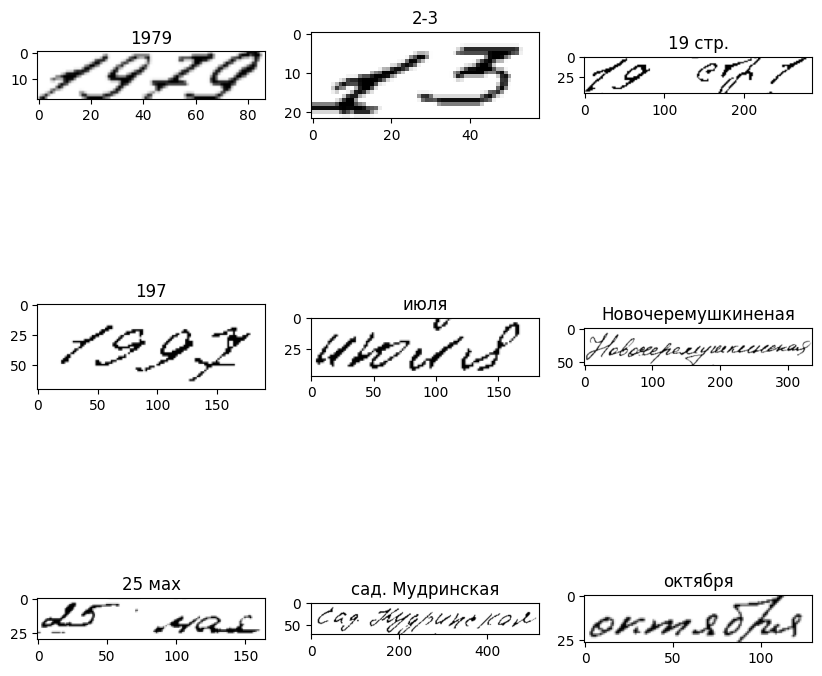

In [80]:
N = 9

images = []
labels = []
for i in range(N):
    idx = i
    image_path = PATH_TEST_DIR + df.iloc[idx]['filename']
    predicted_label = df.iloc[idx]['prediction']

    images.append(Image.open(image_path))
    labels.append(predicted_label)

show_img_grid(images, labels, N)